In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import files

 Load dataset

In [8]:
data = pd.read_csv('/content/drive/MyDrive/Cheapestelectriccars-EVDatabase.csv')

Preprocess the data

In [9]:
def extract_numeric(value):
    if isinstance(value, str):
        return float(''.join([c for c in value if c.isdigit() or c == '.']))
    return value

data['Acceleration'] = data['Acceleration'].apply(extract_numeric)
data['TopSpeed'] = data['TopSpeed'].apply(extract_numeric)
data['PriceinGermany'] = data['PriceinGermany'].apply(extract_numeric)
data['PriceinUK'] = data['PriceinUK'].apply(extract_numeric)

Apply exchange rate and tax adjustments
TAX_RATE_GERMANY 19% VAT
TAX_RATE_UK = 0.20, 20% VAT

In [10]:
EXCHANGE_RATE = 0.85
TAX_RATE_GERMANY = 0.19
TAX_RATE_UK = 0.20

Add converted prices with taxes

In [11]:
data['PriceinGermany_Taxed'] = data['PriceinGermany'] * (1 + TAX_RATE_GERMANY)
data['PriceinUK_Converted_Taxed'] = (data['PriceinGermany'] * EXCHANGE_RATE) * (1 + TAX_RATE_UK)

Select relevant columns and drop missing values

In [12]:
cleaned_data = data[['Acceleration', 'TopSpeed', 'PriceinGermany', 'PriceinUK',
                     'PriceinGermany_Taxed', 'PriceinUK_Converted_Taxed']].dropna()

 Compute and display correlation matrix

In [13]:
correlation_matrix = cleaned_data.corr()
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                           Acceleration  TopSpeed  PriceinGermany  PriceinUK  \
Acceleration                   1.000000 -0.839637       -0.690798  -0.718233   
TopSpeed                      -0.839637  1.000000        0.838137   0.869518   
PriceinGermany                -0.690798  0.838137        1.000000   0.984674   
PriceinUK                     -0.718233  0.869518        0.984674   1.000000   
PriceinGermany_Taxed          -0.690798  0.838137        1.000000   0.984674   
PriceinUK_Converted_Taxed     -0.690798  0.838137        1.000000   0.984674   

                           PriceinGermany_Taxed  PriceinUK_Converted_Taxed  
Acceleration                          -0.690798                  -0.690798  
TopSpeed                               0.838137                   0.838137  
PriceinGermany                         1.000000                   1.000000  
PriceinUK                              0.984674                   0.984674  
PriceinGermany_Taxed              

 Prepare features (X) and target variables for raw and taxed prices

In [14]:
X = cleaned_data[['Acceleration', 'TopSpeed']]

correlations

In [15]:
correlation_price_acceleration = cleaned_data[['PriceinGermany', 'Acceleration']].corr().iloc[0, 1]
correlation_price_top_speed = cleaned_data[['PriceinGermany', 'TopSpeed']].corr().iloc[0, 1]
correlation_acceleration_top_speed = cleaned_data[['Acceleration', 'TopSpeed']].corr().iloc[0, 1]

print(f"Correlation (Price vs Acceleration): {correlation_price_acceleration:.2f}")
print(f"Correlation (Price vs Top Speed): {correlation_price_top_speed:.2f}")
print(f"Correlation (Acceleration vs Top Speed): {correlation_acceleration_top_speed:.2f}")

Correlation (Price vs Acceleration): -0.69
Correlation (Price vs Top Speed): 0.84
Correlation (Acceleration vs Top Speed): -0.84


Visualize correlations using scatter plots

In [16]:
plt.figure(figsize=(18, 6))

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

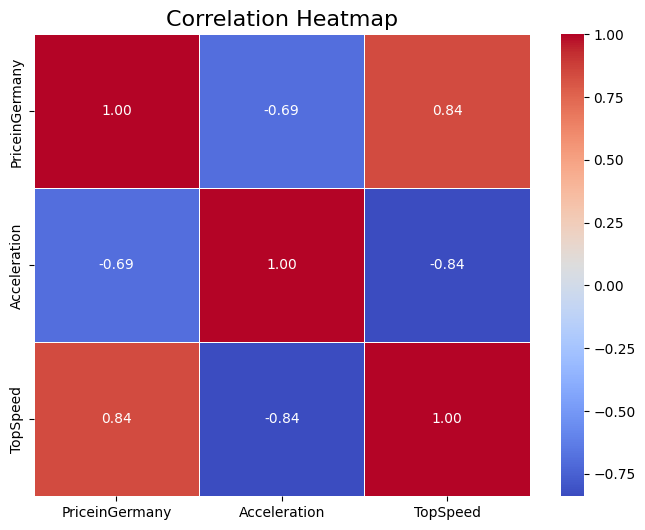

In [17]:
correlation_matrix = cleaned_data[['PriceinGermany', 'Acceleration', 'TopSpeed']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title and labels
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

Correlations between Price vs Acceleration


Text(0, 0.5, 'Price (Germany)')

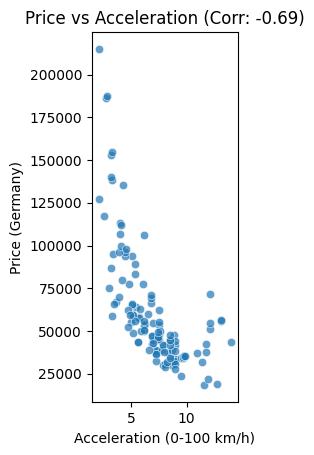

In [27]:
plt.subplot(1,3, 1)
sns.scatterplot(data=cleaned_data, x='Acceleration', y='PriceinGermany', alpha=0.7)
plt.title(f'Price vs Acceleration (Corr: {correlation_price_acceleration:.2f})')
plt.xlabel('Acceleration (0-100 km/h)')
plt.ylabel('Price (Germany)')

Price vs Top Speed

Text(0, 0.5, 'Price (Germany)')

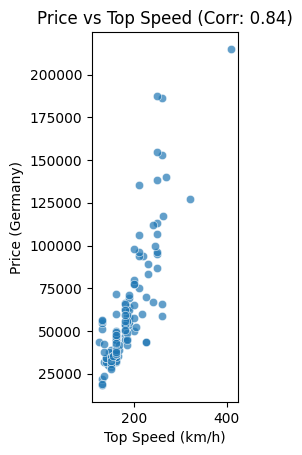

In [ ]:
plt.subplot(1, 3, 2)
sns.scatterplot(data=cleaned_data, x='TopSpeed', y='PriceinGermany', alpha=0.7)
plt.title(f'Price vs Top Speed (Corr: {correlation_price_top_speed:.2f})')
plt.xlabel('Top Speed (km/h)')
plt.ylabel('Price (Germany)')

Acceleration vs Top Speed

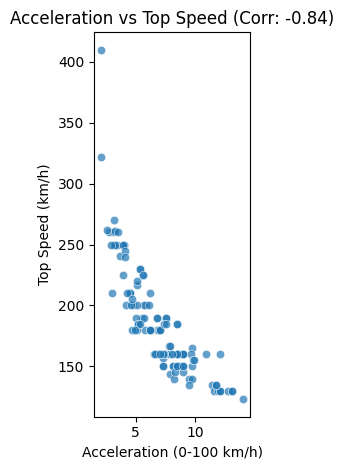

In [ ]:
plt.subplot(1, 3, 3)
sns.scatterplot(data=cleaned_data, x='Acceleration', y='TopSpeed', alpha=0.7)
plt.title(f'Acceleration vs Top Speed (Corr: {correlation_acceleration_top_speed:.2f})')
plt.xlabel('Acceleration (0-100 km/h)')
plt.ylabel('Top Speed (km/h)')

plt.tight_layout()
plt.show()

Raw prices

In [ ]:
y_germany_raw = cleaned_data['PriceinGermany']
y_uk_raw = cleaned_data['PriceinUK']

Taxed prices

In [ ]:
y_germany_taxed = cleaned_data['PriceinGermany_Taxed']
y_uk_taxed = cleaned_data['PriceinUK_Converted_Taxed']

 Split data into training and testing sets

In [ ]:
def split_data(y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Data split: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")
    return X_train, X_test, y_train, y_test

Ensure the correct splits

In [ ]:
X_train_raw_germany, X_test_raw_germany, y_train_raw_germany, y_test_raw_germany = split_data(y_germany_raw)
X_train_taxed_germany, X_test_taxed_germany, y_train_taxed_germany, y_test_taxed_germany = split_data(y_germany_taxed)

X_train_raw_uk, X_test_raw_uk, y_train_raw_uk, y_test_raw_uk = split_data(y_uk_raw)
X_train_taxed_uk, X_test_taxed_uk, y_train_taxed_uk, y_test_taxed_uk = split_data(y_uk_taxed)

Data split: X_train: (101, 2), X_test: (26, 2), y_train: (101,), y_test: (26,)
Data split: X_train: (101, 2), X_test: (26, 2), y_train: (101,), y_test: (26,)
Data split: X_train: (101, 2), X_test: (26, 2), y_train: (101,), y_test: (26,)
Data split: X_train: (101, 2), X_test: (26, 2), y_train: (101,), y_test: (26,)


Function for training and evaluation

In [ ]:
# Function for training and evaluation
def train_and_evaluate(X_train, X_test, y_train, y_test, label):
    # Train models
    linear_model.fit(X_train, y_train)
    random_forest.fit(X_train, y_train)
    gradient_boosting.fit(X_train, y_train)

    # Make predictions
    predictions_linear = linear_model.predict(X_test)
    predictions_rf = random_forest.predict(X_test)
    predictions_gb = gradient_boosting.predict(X_test)

    # Evaluate models
    print(f"\nPerformance Metrics for {label}:")
    for name, predictions in zip(
        ["Linear Regression", "Random Forest", "Gradient Boosting"],
        [predictions_linear, predictions_rf, predictions_gb]
    ):
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

Evaluate raw and taxed prices

In [ ]:
train_and_evaluate(X_train_raw_germany, X_test_raw_germany, y_train_raw_germany, y_test_raw_germany, "Germany (Raw Prices)")
train_and_evaluate(X_train_taxed_germany, X_test_taxed_germany, y_train_taxed_germany, y_test_taxed_germany, "Germany (Taxed Prices)")

train_and_evaluate(X_train_raw_uk, X_test_raw_uk, y_train_raw_uk, y_test_raw_uk, "UK (Raw Prices)")
train_and_evaluate(X_train_taxed_uk, X_test_taxed_uk, y_train_taxed_uk, y_test_taxed_uk, "UK (Taxed Prices)")


Performance Metrics for Germany (Raw Prices):
Linear Regression - MSE: 456454545.03, R2: 0.55
Random Forest - MSE: 528722178.25, R2: 0.47
Gradient Boosting - MSE: 712732115.42, R2: 0.29

Performance Metrics for Germany (Taxed Prices):
Linear Regression - MSE: 646385281.21, R2: 0.55
Random Forest - MSE: 760009069.86, R2: 0.47
Gradient Boosting - MSE: 1009299948.64, R2: 0.29

Performance Metrics for UK (Raw Prices):
Linear Regression - MSE: 252783054.80, R2: 0.56
Random Forest - MSE: 238476619.77, R2: 0.59
Gradient Boosting - MSE: 303688125.27, R2: 0.48

Performance Metrics for UK (Taxed Prices):
Linear Regression - MSE: 474895308.65, R2: 0.55
Random Forest - MSE: 566779024.68, R2: 0.46
Gradient Boosting - MSE: 741526492.88, R2: 0.29


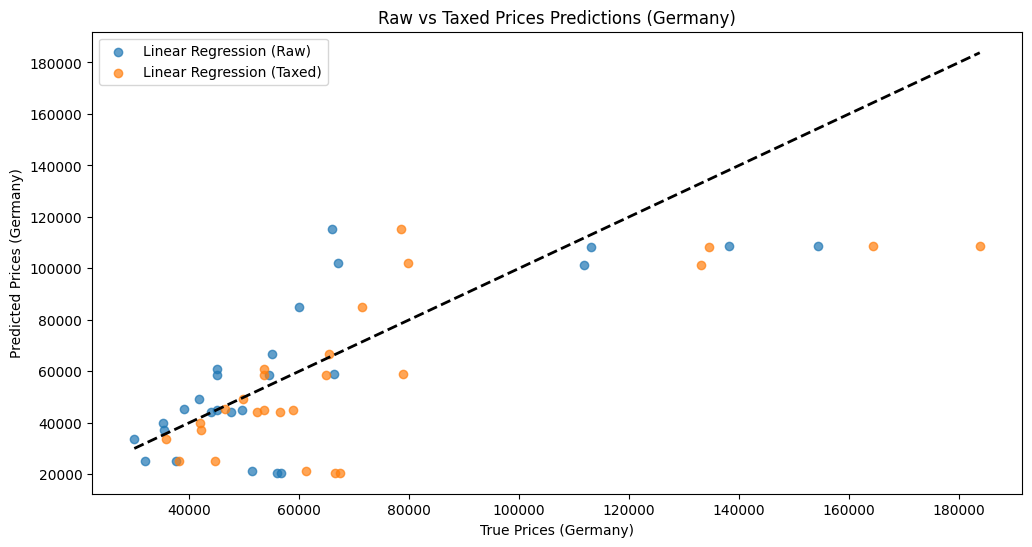

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test_raw_germany, linear_model.predict(X_test_raw_germany), label='Linear Regression (Raw)', alpha=0.7)
plt.scatter(y_test_taxed_germany, linear_model.predict(X_test_taxed_germany), label='Linear Regression (Taxed)', alpha=0.7)
plt.plot([min(y_test_raw_germany.min(), y_test_taxed_germany.min()), max(y_test_raw_germany.max(), y_test_taxed_germany.max())],
         [min(y_test_raw_germany.min(), y_test_taxed_germany.min()), max(y_test_raw_germany.max(), y_test_taxed_germany.max())],
         'k--', lw=2)
plt.xlabel('True Prices (Germany)')
plt.ylabel('Predicted Prices (Germany)')
plt.title('Raw vs Taxed Prices Predictions (Germany)')
plt.legend()
plt.show()

Predicted Prices Germany

full visulization

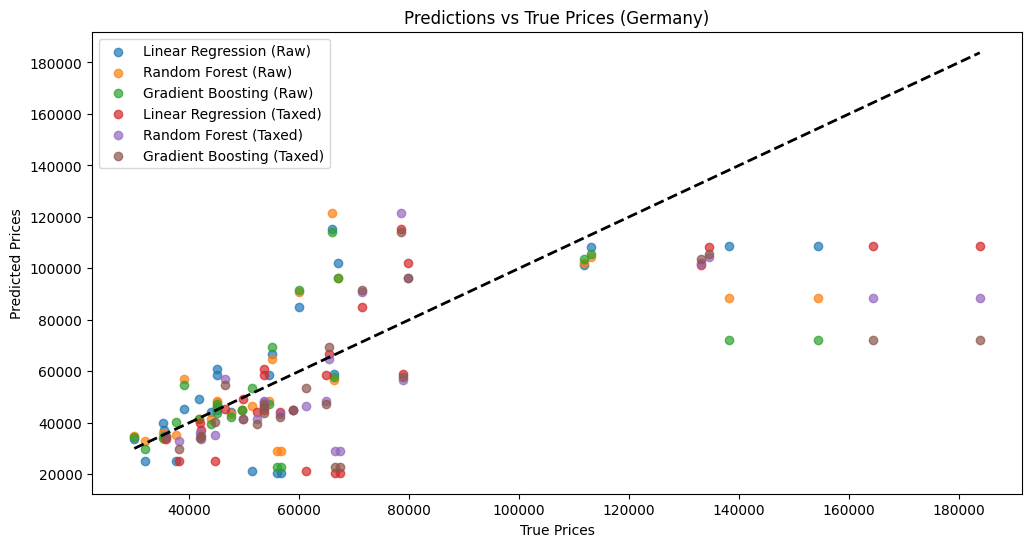

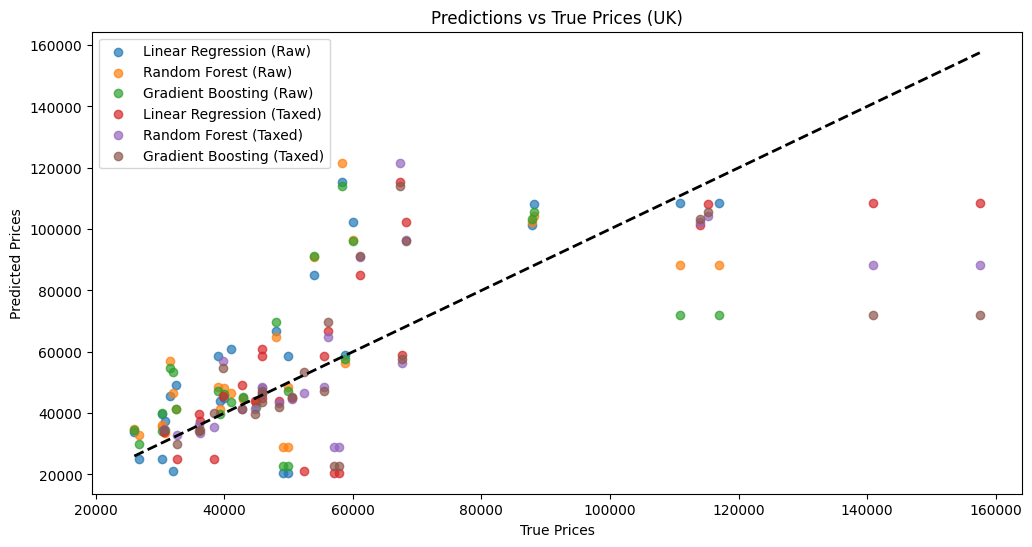

In [ ]:
# Step 1: Visualize predictions for Germany (Raw and Taxed)
def visualize_predictions(y_test_raw, y_test_taxed, X_test_raw, X_test_taxed, label):
    plt.figure(figsize=(12, 6))

    # Plot for raw prices
    plt.scatter(y_test_raw, linear_model.predict(X_test_raw), label=f'Linear Regression (Raw)', alpha=0.7)
    plt.scatter(y_test_raw, random_forest.predict(X_test_raw), label=f'Random Forest (Raw)', alpha=0.7)
    plt.scatter(y_test_raw, gradient_boosting.predict(X_test_raw), label=f'Gradient Boosting (Raw)', alpha=0.7)

    # Plot for taxed prices
    plt.scatter(y_test_taxed, linear_model.predict(X_test_taxed), label=f'Linear Regression (Taxed)', alpha=0.7)
    plt.scatter(y_test_taxed, random_forest.predict(X_test_taxed), label=f'Random Forest (Taxed)', alpha=0.7)
    plt.scatter(y_test_taxed, gradient_boosting.predict(X_test_taxed), label=f'Gradient Boosting (Taxed)', alpha=0.7)

    # Add diagonal line for reference
    all_prices = pd.concat([y_test_raw, y_test_taxed])
    plt.plot([all_prices.min(), all_prices.max()], [all_prices.min(), all_prices.max()], 'k--', lw=2)

    plt.xlabel('True Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Predictions vs True Prices ({label})')
    plt.legend()
    plt.show()

# Visualize for Germany
visualize_predictions(y_test_raw_germany, y_test_taxed_germany, X_test_raw_germany, X_test_taxed_germany, "Germany")

# Visualize for UK
visualize_predictions(y_test_raw_uk, y_test_taxed_uk, X_test_raw_uk, X_test_taxed_uk, "UK")
